User ID Length Analysis:
Summary Statistics:
count    151112.000000
mean          5.724059
std           0.510414
min           1.000000
25%           6.000000
50%           6.000000
75%           6.000000
max           6.000000
Name: user_id_length, dtype: float64

Correlation with Target:
                user_id_length   class
user_id_length          1.0000 -0.0029
class                  -0.0029  1.0000


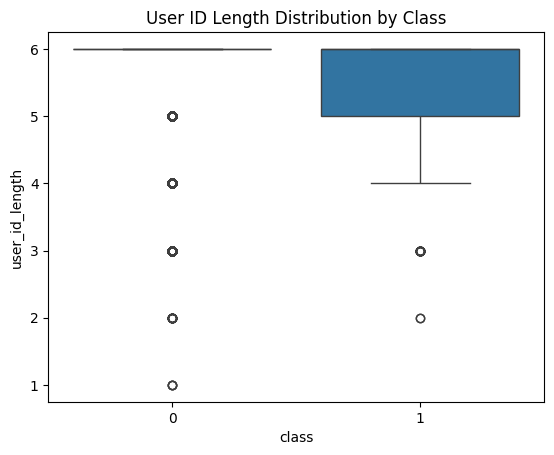


Purchase Value Analysis:
Summary Statistics:
count    151112.000000
mean         36.935372
std          18.322762
min           9.000000
25%          22.000000
50%          35.000000
75%          49.000000
max         154.000000
Name: purchase_value, dtype: float64

Outliers Analysis:


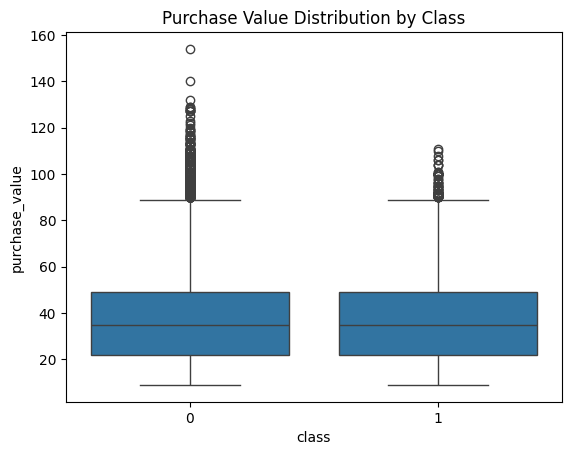


Country Encoding Analysis:
Frequency of Transactions by Country:
171    58049
172    21966
36     12038
84      7306
170     4490
       ...  
114        1
175        1
49         1
122        1
68         1
Name: country_encoded, Length: 182, dtype: int64

Fraudulent Transactions by Country:
171    5551
172    1883
36     1043
84      715
170     477
       ... 
102       1
146       1
166       1
100       1
106       1
Name: country_encoded, Length: 110, dtype: int64


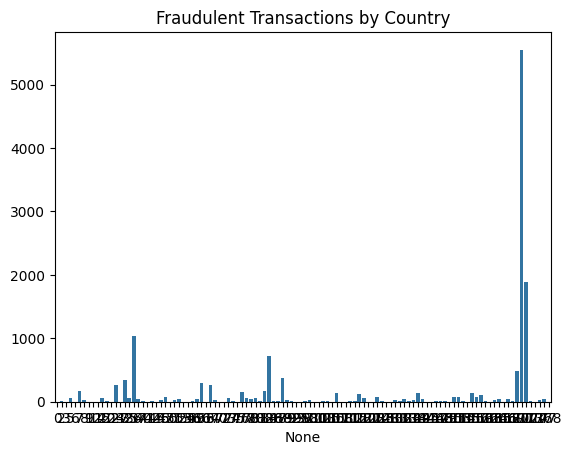


Correlation Analysis:
                 user_id_length  purchase_value  country_encoded     class
user_id_length         1.000000        0.002339         0.001342 -0.002900
purchase_value         0.002339        1.000000        -0.003412  0.001011
country_encoded        0.001342       -0.003412         1.000000 -0.001160
class                 -0.002900        0.001011        -0.001160  1.000000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Anomaly Detection Results:
Number of Anomalies: 14323


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Accuracy: 0.9039403465165582


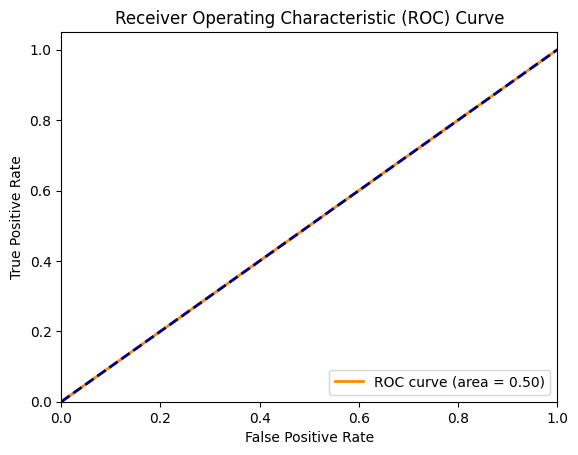

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

# Load the modified dataset
data = pd.read_csv('/content/modified_dataset.csv')

# Step 1: User ID Length Analysis
print("User ID Length Analysis:")
print("Summary Statistics:")
print(data['user_id_length'].describe())
print("\nCorrelation with Target:")
print(data[['user_id_length', 'class']].corr())
sns.boxplot(x='class', y='user_id_length', data=data)
plt.title("User ID Length Distribution by Class")
plt.show()

# Step 2: Purchase Value Analysis
print("\nPurchase Value Analysis:")
print("Summary Statistics:")
print(data['purchase_value'].describe())
print("\nOutliers Analysis:")
sns.boxplot(x='class', y='purchase_value', data=data)
plt.title("Purchase Value Distribution by Class")
plt.show()

# Step 3: Country Encoding Analysis
print("\nCountry Encoding Analysis:")
print("Frequency of Transactions by Country:")
print(data['country_encoded'].value_counts())
print("\nFraudulent Transactions by Country:")
fraud_by_country = data[data['class'] == 1]['country_encoded'].value_counts()
print(fraud_by_country)
sns.barplot(x=fraud_by_country.index, y=fraud_by_country.values)
plt.title("Fraudulent Transactions by Country")
plt.show()

# Step 4: Correlation Analysis
print("\nCorrelation Analysis:")
print(data[['user_id_length', 'purchase_value', 'country_encoded', 'class']].corr())

# Step 5: Feature Engineering
# No specific feature engineering applied in this code snippet

# Step 6: Anomaly Detection using Isolation Forest
X = data[['user_id_length', 'purchase_value', 'country_encoded']]
if_classifier = IsolationForest(contamination=0.095)
anomaly_preds = if_classifier.fit_predict(X)
anomaly_indices = anomaly_preds == -1  # Anomalies are labeled as -1
print("\nAnomaly Detection Results:")
print("Number of Anomalies:", anomaly_indices.sum())

# Step 7: Remove anomalies from the dataset
X_cleaned = X[~anomaly_indices]
y_cleaned = data.loc[~anomaly_indices, 'class']

# Step 8: Train multiple classification algorithms on the cleaned dataset
# Define classifiers
svm_classifier = SVC(probability=True)
logistic_classifier = LogisticRegression()
xgb_classifier = XGBClassifier()
rf_classifier = RandomForestClassifier()

# Step 9: Use ensemble bagging to combine the predictions of these classifiers
bagging_classifier = BaggingClassifier(base_estimator=VotingClassifier(estimators=[
    ('SVM', svm_classifier),
    ('LogisticRegression', logistic_classifier),
    ('XGBoost', xgb_classifier),
    ('RandomForest', rf_classifier)
]), n_estimators=10, random_state=42)

# Step 10: Split the cleaned dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Step 11: Train the ensemble bagging classifier
bagging_classifier.fit(X_train, y_train)

# Step 12: Evaluate the ensemble bagging classifier
accuracy = bagging_classifier.score(X_test, y_test)
print("\nAccuracy:", accuracy)

# Step 13: Compute ROC curve and ROC area for each class
y_score = bagging_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Step 14: Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
